#### CPSC 330 - Applied Machine Learning 

## Homework 3: Preprocessing 
### Associated lectures: [Lectures 4, 5, 6](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Wednesday, Feb 01, 2023 at 11:59pm**

## Table of Contents

- [Instructions](#si)
- [Introduction](#in)
- [Exercise 1: Introducing the dataset](#1)
- [Exercise 2: Exploratory data analysis (EDA)](#2)
- [Exercise 3: Preprocessing](#3)
- [Exercise 4: Building models](#4)
- [Exercise 5: Evaluating on the test set](#5)

## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as math
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Instructions <a name="si"></a>
<hr>
rubric={points:6}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework (maximum group size: 2).** 

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

## Introduction <a name="in"></a>
<hr>

A crucial step when using machine learning algorithms on real-world datasets is preprocessing. This homework will give you some practice of data preprocessing and building a supervised machine learning pipeline on a real-world dataset. 

<br><br>

## Exercise 1: Introducing the dataset <a name="1"></a>
<hr>

In this lab, you will be working on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). Download the CSV and save it as `adult.csv` locally in this homework folder. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The starter code below loads the data CSV (assuming that it is saved as `adult.csv` in this folder). 

_Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

In [2]:
census_df = pd.read_csv("./adult.csv")
census_df.shape

(32561, 15)

<br><br>

### 1.1 Data splitting 
rubric={points:4}

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

**Your tasks:**

1. Split the data into `train_df` (60%) and `test_df` (40%) with `random_state = 42`. Keep the target column (`income`) in the splits so that we can use it in the exploratory data analysis.  

_Usually having more data for training is a good idea. But here we're using a 60%/40% split because this is kind of a big dataset for a modest laptop. A smaller training set means that it won't take too long to train the model on your laptop. A side advantage of this would be that with a bigger test split, we'll have a more reliable estimate of the deployment performance!_

In [3]:

train_df, test_df = train_test_split(census_df, test_size = 0.4, random_state = 42)

<br><br>

## Exercise 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [4]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,43,Private,84661,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,<=50K
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32555,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K


We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values as they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.nan` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [5]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

(19536, 15)

In [6]:
train_df_nan.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,NaN,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,43,Private,84661,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,<=50K
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32555,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K


The "?" symbols are now replaced with NaN values. 

<br><br>

### 2.1 Visualizing features
rubric={points:10}

**Your tasks:**

1. Examine the information given by `train_df_nan.info()` and `train_df_nan.describe()` methods. In case of `.describe()`, use the `include="all"` argument to show summary statistics of all  features.
2. Visualize the histograms of numeric features. 
3. From the visualizations, which features seem relevant for the given prediction task?

> Note: (Optional) If you're feeling excited about this you are welcome to use [`pandas_profiling`](https://github.com/pandas-profiling/pandas-profiling) for more elaborate visualization and EDA. 

In [7]:
train_df_nan.info()
train_df_nan.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19536 entries, 25823 to 23654
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             19536 non-null  int64 
 1   workclass       18428 non-null  object
 2   fnlwgt          19536 non-null  int64 
 3   education       19536 non-null  object
 4   education.num   19536 non-null  int64 
 5   marital.status  19536 non-null  object
 6   occupation      18424 non-null  object
 7   relationship    19536 non-null  object
 8   race            19536 non-null  object
 9   sex             19536 non-null  object
 10  capital.gain    19536 non-null  int64 
 11  capital.loss    19536 non-null  int64 
 12  hours.per.week  19536 non-null  int64 
 13  native.country  19187 non-null  object
 14  income          19536 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.4+ MB


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,19536.000000,18428,1.953600e+04,19536,19536.000000,19536,18424,19536,19536,19536,19536.000000,19536.000000,19536.000000,19187,19536
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,13570,NaN,6256,NaN,9025,2490,7937,16676,13079,NaN,NaN,NaN,17517,14841
mean,38.592547,NaN,1.892662e+05,NaN,10.084767,NaN,NaN,NaN,NaN,NaN,1090.443540,86.537162,40.532606,NaN,NaN
std,13.638971,NaN,1.049020e+05,NaN,2.580723,NaN,NaN,NaN,NaN,NaN,7449.700833,402.395668,12.406636,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.177670e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.782835e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,47.000000,NaN,2.368860e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


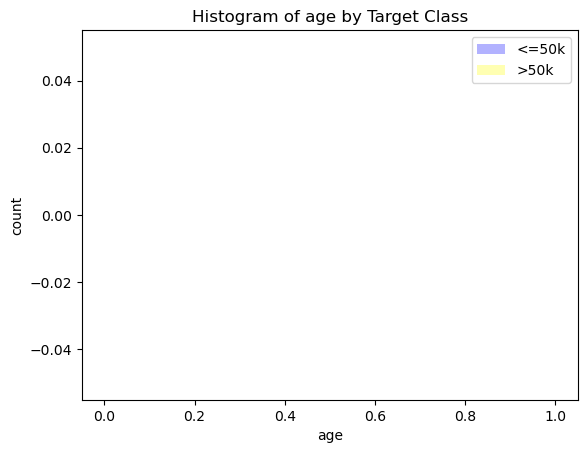

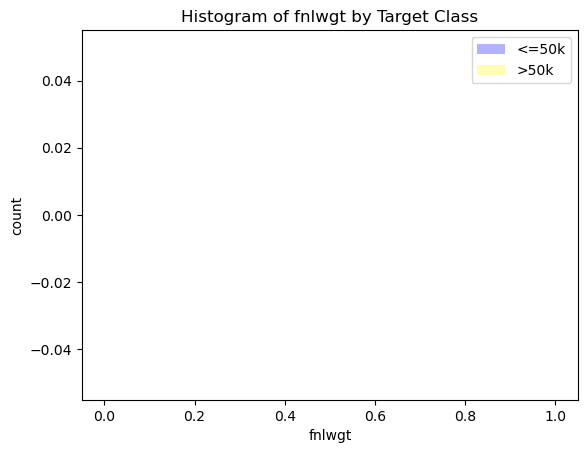

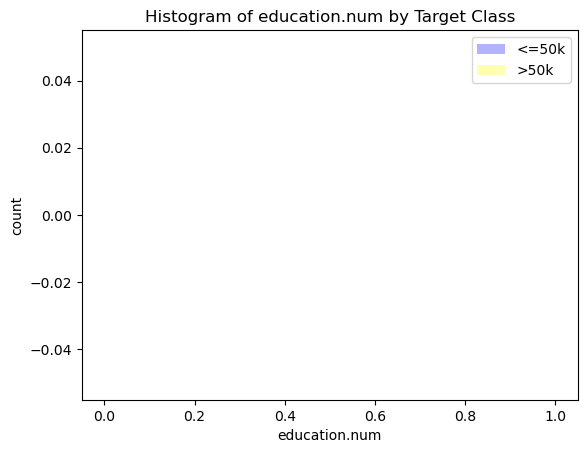

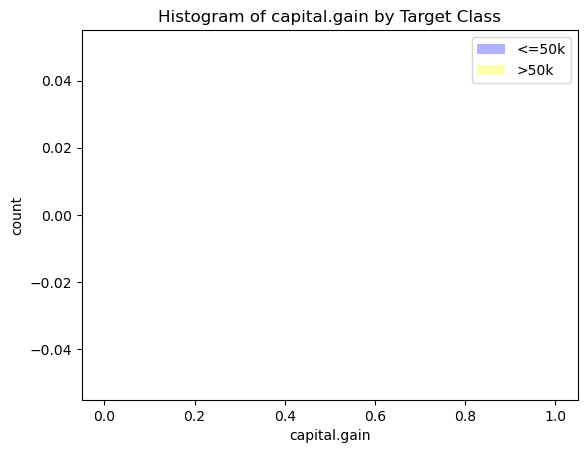

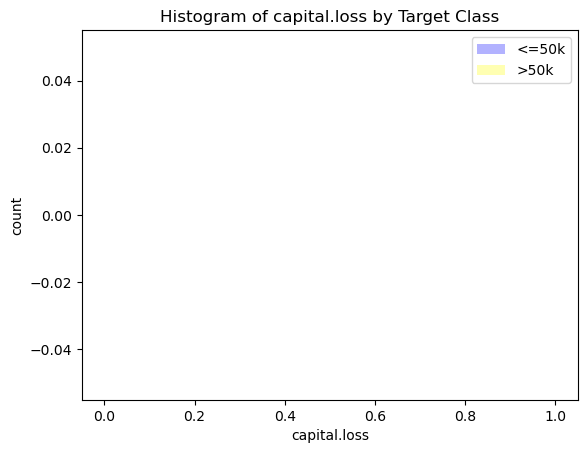

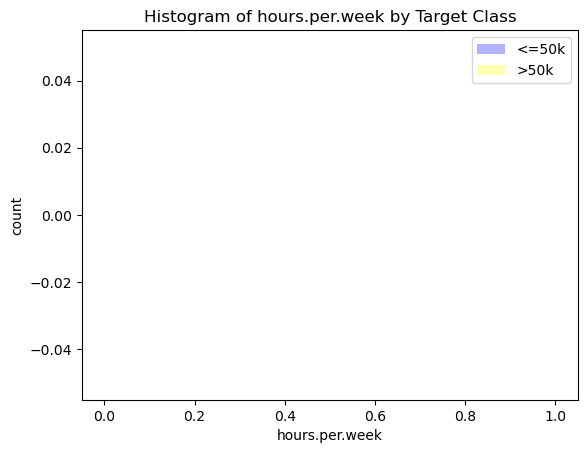

In [8]:
from math import sqrt

numeric_df = train_df_nan.select_dtypes(include=[np.number])

negative_examples = train_df_nan.query("income == '<=50k'")
positive_examples = train_df_nan.query("income == '>50k'")



for feature in numeric_df:
    positive_data = positive_examples[feature]
    negative_data = negative_examples[feature]
    plt.title('Histogram of ' + feature + ' by Target Class')
    plt.hist(negative_data, bins=round(math.sqrt(len(numeric_df))), color="blue", alpha = 0.3, label = '<=50k')
    plt.hist(positive_data, bins=round(math.sqrt(len(numeric_df))), color="yellow", alpha = 0.3, label = '>50k')
    plt.legend()
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.show()


<br><br>

### 2.2 Identify transformations to apply
rubric={points:18}

**Your tasks:**
1. Identify the sequence of transformations that you would apply on each column in the dataset and fill in the table below accordingly. An example of the sequence of transformations to be applied on the `occupation` feature is shown in the table below. You may decide not to apply any transformations on a certain column or entirely drop a column from your model. That's totally fine. 
2. Are there common transformations you would like to apply on certain types of features? Identify different feature types for applying different transformations. In particular, fill in the lists below. 
3. Is including the `race` feature for predicting income ethically a good idea? Briefly discuss. 

> Note: This question is a bit open-ended and there is no single correct solution.

| Feature | Transformation |
| --- | ----------- |
| occupation | imputation, OHE |
| age | Scale |
| workclass | imputation, OHE |
| education | drop |
| education.num | Scale |
| marital.status | OHE |
| relationship |  OHE |
| race | OHE |
| sex | OHE or Binarization |
| capital.gain | Scale |
| capital.loss | Scale |
| hours.per.week | Scale |
| native.country | imputation, OHE |


In [9]:
# Fill in the lists below. 
# It's OK to keep some of the lists empty or add new lists. 
numeric_features = ["age", "education.num", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = ["education", "occupation", "workclass", "marital.status", "relationship", "race", "sex", "native.country" ]
ordinal_features = []
binary_features = ["sex", "income"]
drop_features = ["education"]
passthrough_features = []
target = "income"

The 'race' feature may provide some predicting power for income, however, ethically it may not be a good idea as it is something that individuals can not change unlike features such as marital status, or work hours per week. 

<br><br>

### 2.3 Separating feature vectors and targets  
rubric={points:4}

**Your tasks:**

1. Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df_nan` and `test_df_nan`. 
2. At this point, if you train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train` would it work? Why or why not?

In [12]:
X_train, y_train = ( 
    train_df_nan.drop(columns = ["income"]),
    train_df_nan["income"],
)

X_test, y_test = ( 
    test_df_nan.drop(columns = ["income"]),
    test_df_nan["income"],
)

2. no, the categorical data needs to be encoded numerically. So transformations must be made on the categorical features listed next.
categorical_features = [['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income' ]]


<br><br><br><br>

## Exercise 3: Preprocessing <a name="3"></a>
<hr>

### 3.1 Preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`
rubric={points:18}

Let's carry out preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`. Note that you can define pipelines in two ways: 
- by using [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and explicitly providing named steps
- by using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline), which automatically names the steps in the pipeline with their class names. 

Similarly you can create a column transformer in two ways:
- by using [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
- by using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) 

You may use the method of your choice but `make_pipeline` and `make_column_transformer` are highly recommended.  

**Your tasks:**

1. Create a column transformer `preprocessor` based on transformations you want to apply on the data from 2.2. 
2. Transform the data by calling `fit_transform` on the training set. What's the shape of the transformed data? 
3. Why do we need to use a column transformer in this case? Briefly explain. 

In [17]:
numeric_feats = ["age", "education.num", "capital.gain", "capital.loss", "hours.per.week"]
categorical_feats = ["occupation", "workclass", "marital.status", "relationship", "race", "sex", "native.country" ]
pass_through_feats = []
drop_features = ["education"]

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_feats),
    (OneHotEncoder(handle_unknown="ignore", sparse = False), categorical_feats),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
)

transformed = preprocessor.fit_transform(X_train, y_train)
transformed.shape

(19536, 91)

Column transformer is used as we have different data types for the different columns and we want to apply different transformations for each type. This is handled by using the column transformed model. 

<br><br><br><br>

## Exercise 4: Building models <a name="4"></a>
<hr>

Now that we have preprocessed features, we are ready to build models. Below is the function we used in class, which returns the mean cross-validation score along with standard deviation for a given model. Feel free to use it to keep track of your results if you like. 

In [18]:
results_dict = {} # dictionary to store all the results

In [19]:

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br>

### 4.1 Baseline model 
rubric={points:6}

**Your tasks:**
1. Define a pipeline with two steps: `preprocessor` from 3.1 and `scikit-learn`'s `DummyClassifier` with `strategy="prior"` as your classifier.  
2. Carry out 5-fold cross-validation with the pipeline. Store the results in `results_dict` above. Display the results as a pandas DataFrame.  

> You may use the function `mean_std_cross_val_scores` above to carry out cross-validation and storing results. Refer to the class notes if you are unsure about how to use it. 

pipe = make_pipeline(preprocessor, DummyClassifier(strategy="prior"))

<br><br>

In [20]:
pipe = make_pipeline(preprocessor, DummyClassifier(strategy="prior"))

In [21]:


results_dict["preprocessor + classifier"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, return_train_score=True)

pd.DataFrame(results_dict)

,preprocessor + classifier
fit_time,0.062 (+/- 0.014)
score_time,0.031 (+/- 0.007)
test_score,0.760 (+/- 0.000)
train_score,0.760 (+/- 0.000)


### 4.2 Trying different classifiers
rubric={points:14}

**Your tasks:**

1. For each of the models in the starter code below: 
    - Define a pipeline with two steps: `preprocessor` from 3.1 and the model as your classifier. 
    - Carry out 5-fold cross-validation with the pipeline.  
    - Store the results in `results_dict`. 
2. Display all the results so far as a pandas dataframe. 
3. Compare the train and validation accuracies and `fit` and `score` times in each case. How do the the validation accuracies compare to the baseline model from 4.1? Which model has the best validation accuracy? Which model is the fastest one?  

> Note that this might take a while to run.

> You may use the function above `mean_std_cross_val_scores` to carry out cross-validation and storing results. Refer to the class notes if you are unsure about how to use it. 

In [22]:
models = {
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
}

pipe1 = make_pipeline(preprocessor, DecisionTreeClassifier())
pipe2 = make_pipeline(preprocessor, KNeighborsClassifier())
pipe3 = make_pipeline(preprocessor, SVC())

results_dict["preprocessor + DecisionTree"] = mean_std_cross_val_scores(
    pipe1, X_train, y_train, return_train_score=True)
results_dict["preprocessor + kNN"] = mean_std_cross_val_scores(
    pipe2, X_train, y_train, return_train_score=True)
results_dict["preprocessor + RBF SVM"] = mean_std_cross_val_scores(
    pipe3, X_train, y_train, return_train_score=True)

pd.DataFrame(results_dict)


,preprocessor + classifier,preprocessor + DecisionTree,preprocessor + kNN,preprocessor + RBF SVM
fit_time,0.062 (+/- 0.014),0.226 (+/- 0.038),0.061 (+/- 0.004),14.741 (+/- 2.019)
score_time,0.031 (+/- 0.007),0.024 (+/- 0.002),0.592 (+/- 0.074),6.125 (+/- 0.708)
test_score,0.760 (+/- 0.000),0.818 (+/- 0.006),0.832 (+/- 0.004),0.855 (+/- 0.007)
train_score,0.760 (+/- 0.000),0.984 (+/- 0.000),0.883 (+/- 0.001),0.866 (+/- 0.001)


The faster model in both fit and score times is still the preprocessor + DecisionTreeClassifier() pipeline. This model also has the highest train scores vs the other pipelines. All pipelines have better train and validation scores than the DummyClassifier pipeline created in 4.1. The model with the best validation score is the preprocessor + SVM pipeline, although its training score was the worst amongst the three. 

### (optional) 4.3 Exploring the importance of scaling
rubric={points:1}

In this exercise you'll examine whether scaling helps in case of KNNs and SVM RBFs. 

**Your tasks:**

1. Create a column transformer without the `StandardScaler` step for `numeric_features`. 
2. Repeat the steps in 4.2 with this new column transformer. 
3. Compare the results of scaled numeric features with unscaled numeric features. Is scaling necessary for decision trees? Why or why not?

### 4.4 Hyperparameter optimization
rubric={points:10}

In this exercise, you'll carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. In practice you'll carry out hyperparameter optimization for all different hyperparameters for the most promising classifiers. For the purpose of this assignment, we'll only do it for the `SVC` classifier with one hyperparameter: `C`. 

**Your tasks:**

1. For each `C` value in the `param_grid` in the starter code below: 
    - Create a pipeline object with two steps: preprocessor from 3.1 and `SVC` classifier with the value of `C`.
    - Carry out 5-fold cross validation with the pipeline.  
    - Store the results in `results_dict` and display results as a pandas DataFrame. 
2. Which hyperparameter value seems to be performing the best, and why? Is it different than the default value for the hyperparameter used by `scikit-learn`? 

> Note: Running this might take a while. 

In [24]:
param_vals = np.logspace(-2, 2, num=5, base=10)
param_grid = {"C": np.delete(param_vals, np.where(param_vals == 1.0))}

for value in param_grid["C"]:
    pipe = make_pipeline(preprocessor, SVC(C = value))
    results_dict[f"SVC (C:{value})"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score = True)
    
pd.DataFrame(results_dict)

KeyboardInterrupt: 

<br><br><br><br>

## Exercise 5: Evaluating on the test set <a name="5"></a>
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set. In this exercise you'll examine whether the results you obtained using cross-validation on the train set are consistent with the results on the test set. 

### 5.1 Scoring on the unseen test set 
rubric={points:10}

**Your tasks:**

1. Train the best performing model on the entire training set. 
2. Report the results of this model on `X_test`. 
3. Are the cross-validation results and test results consistent? 

In [ ]:
best_pipe = make_pipeline(preprocessor, SVC(C = 1))

best_pipe.fit(X_train, y_train)

best_pipe.predict(X_test)


## Exercise 6: Summary

rubric={Pass/Fail}

You are all done with Homework 3! Your last task is reflecting on what you have learned and answering the following questions. **This task is necessary to pass HW3**. Failing to complete this task means you will not receive points for this assignment.

1. In about 100 words, describe what you have learned from this homework.
2. Write at least one well-formulated question on something that is still not clear about the content of this homework, or you would like to know more about.

*Your answer here*

1. In this homework assignment, we learned the full implementation of preprocessing and prediciting on a dataset containing different datatypes. After loading and reading the dataset, we split the set 60/40 into training and testing splits using train_test_split(). We carried out manual imputation and replaced all missing values of "?" with NaN in both the train and test splits using df.replace("?", np.nan). We then visualized the numeric data columns (.info() and .describe(include="all") to determine which features seemed relevant for prediction. This was based on whether or not the positive or negative target classes had distributions that overlapped or not. We then identitifed specific data transformations by column data type and seperated the columns by datatype in arrays of column names. After seperating the train and test splits into X and Y dataframes we used make_pipeline() or make_column_transformer() to create our preprocessor with different features associated with their specific transformers. Be sure to set OHE parameters handle_unknown to "ignore" and sparse = false to handle unknown column fields that may be encountered in testing. We then created multiple pipelines with this preprocessor and different classifiers (Dummy, DecisionTree, KNN, RBF SVC) and compared their timings and scores using mean_std_cross_val_scores(). We carried out hyperparameter optimization for the RBF SVC pipeline to optimize for the best value of C with cross validation. Finally, we evaluated the efficacy of the best classifier model on our test split.

2. Are there better ways to validate that our transformation have been accurately chosen and performed on the dataset besides just printing info about the transformed data? It seems that there are rigidly set protocols for transformation on the different types of dataset. By this, is there a way that we can query the dataset for the suggested gold standard transformations. 

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

This was a tricky one but I hope you are feeling good after working on it. You are now ready to build a simple supervised machine learning pipeline on real-world datasets! Well done (**and don't forget to submit**)! 

![](./eva-well-done.png)

